<h1 align=center><font size = 5>Rental Listing Inquiries </font></h1>

I am going to predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc.

Let’s start with installing appropriate packages and importing the data.


### Install the packages 

In [1]:
install.packages("jsonlite")
install.packages("rjson")
install.packages("dplyr")
install.packages("purrr")
install.packages("nnet")
install.packages("ggplot2")
install.packages("tm")
install.packages("wordcloud")
install.packages("data.table")
install.packages("rpart")
install.packages("rpart.plot")
install.packages("C50")
install.packages("class")


Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)
Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)
Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)
Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)
Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)
Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)
Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘NLP’, ‘slam’

Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)
Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)


Now call the libraries:

In [131]:

library("data.table")
library("rjson")
library("dplyr")
library("purrr")
library("ggplot2")
library("tm")
library("wordcloud")
library("nnet")
library("rpart")
library("rpart.plot")
library("C50")
require("class")

### importing the data

In [132]:
train <- fromJSON('/resources/data/train.json')

In [133]:
test <- fromJSON('/resources/data/test.json')


This data set contains text and pictures and each item store as a list therefore the best way to read this kind of data set is to use library **purrr**. So we have:

In [17]:

varstrain <- setdiff(names(train), c("photos", "features"))
dftrain <- map_at(train, varstrain, unlist) %>% tibble::as_tibble(.)

varstest <- setdiff(names(test), c("photos", "features"))
dftest <- map_at(test, varstest, unlist) %>% tibble::as_tibble(.)


Our dataset is well imported.


First step, before modeling is obtaining an idea about our data set. Having a good knowledge about data set helps us to identify a better model.


and let’s look at its format:

In [134]:
colnames(dftrain)
head(summary(dftrain))

 [1] "bathrooms"       "bedrooms"        "building_id"     "created"        
 [5] "description"     "display_address" "features"        "latitude"       
 [9] "listing_id"      "longitude"       "manager_id"      "photos"         
[13] "price"           "street_address"  "interest_level" 

   bathrooms        bedrooms     building_id          created         
 1      :39422   1      :15752   Length:49352       Length:49352      
 2      : 7660   2      :14623   Class :character   Class :character  
 3      :  745   0      : 9475   Mode  :character   Mode  :character  
 1.5    :  645   3      : 7276                                        
 0      :  313   4      : 1929                                        
 2.5    :  277   5      :  247                                        
 description        display_address   
 Length:49352       Length:49352      
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      
 features.Length  features.Class  features.Mode    latitude    
  7         -none-     character                Min.   : 0.00  
  6         -none-     character                1st Qu.:40.73  
  6         -none-     character      

As it can be seen, our data is not in an appropriate format to analysis, for instance: the variable bedrooms and bathrooms stored as numeric variables. The data should be changed into appropriate format. let's make it:

In [ ]:

table(as.character(dftrain$building_id))
table(as.character(dftrain$manager_id))


two variables, **building_id** and **manager_ id** should be removed from our data set. These variables do not add any necessary information to our model due to their high variability. 

Other things that we can mention here is:

**street_address** is the real address of the flat. **display_address** is the address that appears in RentHop website. I prefer to use the **Latitude** and **longitude** as some geographic positions on the surfaces of earth instead of using display_address or street_address.

Feature, discription and photo contain txt and pictures, for these variables, I want to investigate any relationship between the number of photos or words in listing and level of interes?


Now, I am going to change the variable's format: 


In [75]:
dftrain$bathrooms<- as.factor(dftrain$bathrooms)
dftrain$bedrooms<-as.factor(dftrain$bedrooms)
created_train <- strptime(dftrain$created, format = "%Y-%m-%d %H:%M:%S")
creat_month <- as.numeric(month(created_train))
creat_hour <-as.numeric(hour(created_train))
creat_day <-as.numeric(wday(created_train))
dftrain$listing_id<- as.character(dftrain$listing_id)
dftrain$interest_level<- as.factor(dftrain$interest_level)
feature_count <- as.numeric(lapply(dftrain$features, length))
photo_count <- as.numeric(lapply(dftrain$features, length))


### Defining the Final Dataframe

In [65]:
colnames(dftrain)
dftrain_red<- data.frame(dftrain[,-c(3,4,5,6,7,11,12,14)], creat_month,creat_hour,creat_day, feature_count,photo_count)
colnames(dftrain_red)

 [1] "bathrooms"       "bedrooms"        "building_id"     "created"        
 [5] "description"     "display_address" "features"        "latitude"       
 [9] "listing_id"      "longitude"       "manager_id"      "photos"         
[13] "price"           "street_address"  "interest_level" 

 [1] "bathrooms"      "bedrooms"       "latitude"       "listing_id"    
 [5] "longitude"      "price"          "interest_level" "creat_month"   
 [9] "creat_hour"     "creat_day"      "feature_count"  "photo_count"   

### Cleaning the Final Dataframe

First Step for cleaning the data is dealing with missing or **NA** values. na.omit function returns the object with incomplete cases removed.

In [66]:
dftrain_red<-na.omit(dftrain_red)

    0     1   1.5     2   2.5     3   3.5     4   4.5     5   5.5     6   6.5 
  313 39422   645  7660   277   745    70   159    29    20     5     4     1 
    7    10 
    1     1 

    0     1     2     3     4     5     6     7     8 
 9475 15752 14622  7276  1929   246    46     1     2 

Empty data.table (0 rows) of 13 cols: listing_id,bathrooms,bedrooms,latitude,longitude,price...
NULL

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   40.73   40.75   40.74   40.77   44.88 

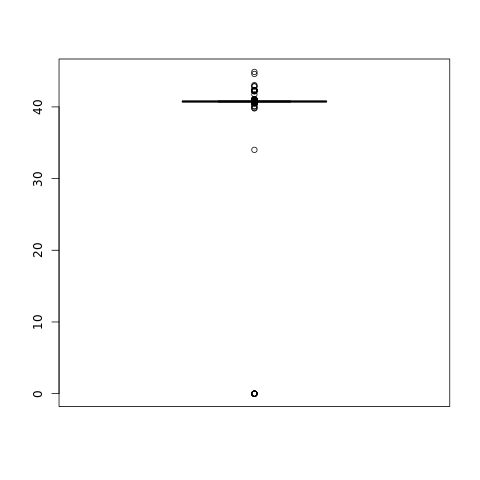

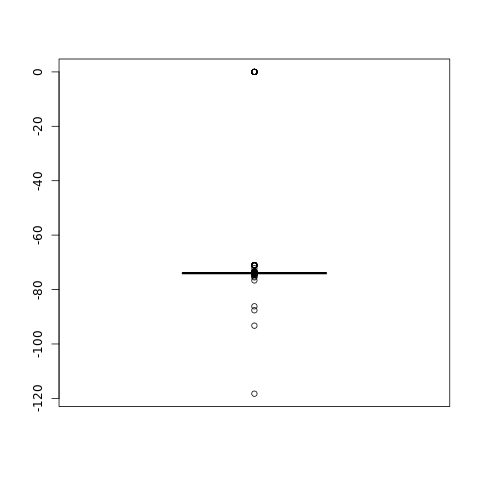

 [1] "7087715" "7094527" "7174094" "6981091" "6991620" "6997950" "6991901"
 [8] "7062134" "6991613" "7072634" "6896885" "6888639"

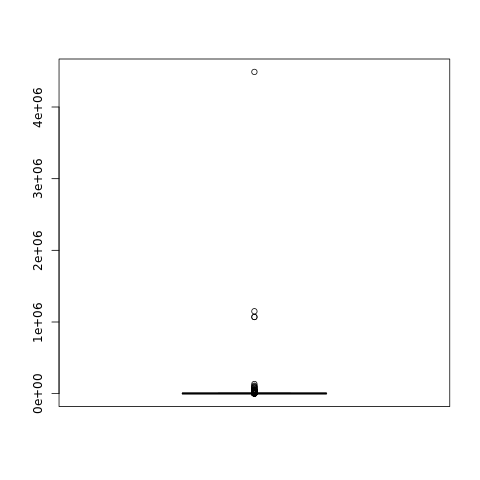

   bathrooms        bedrooms        latitude      listing_id       
 1      :39406   1      :15746   Min.   :34.01   Length:49328      
 2      : 7660   2      :14615   1st Qu.:40.73   Class :character  
 3      :  743   0      : 9472   Median :40.75   Mode  :character  
 1.5    :  645   3      : 7275   Mean   :40.75                     
 0      :  313   4      : 1929   3rd Qu.:40.77                     
 2.5    :  277   5      :  246   Max.   :44.88                     
 (Other):  284   (Other):   45                                     
   longitude           price        interest_level  creat_month   
 Min.   :-118.27   Min.   :   401   high  : 3839   Min.   :4.000  
 1st Qu.: -73.99   1st Qu.:  2500   low   :34262   1st Qu.:4.000  
 Median : -73.98   Median :  3150   medium:11227   Median :5.000  
 Mean   : -73.97   Mean   :  3671                  Mean   :5.015  
 3rd Qu.: -73.95   3rd Qu.:  4100                  3rd Qu.:6.000  
 Max.   : -70.98   Max.   :135000                  Max

In [67]:
############clean the bathroom variable

summary(dftrain_red$bathrooms)

dftrain_red <- dftrain_red [!(dftrain_red$bathrooms == 6.5),]
dftrain_red <- dftrain_red [!(dftrain_red$bathrooms == 7),]
dftrain_red <- dftrain_red [!(dftrain_red$bathrooms == 10),]

############cleaning the bedroom variable

summary(dftrain_red$bedrooms)

dftrain_red <- dftrain_red [!(dftrain_red$bedrooms == 7),]
dftrain_red <- dftrain_red [!(dftrain_red$bedrooms == 8),]

###########cleaning listing_id

dt = data.table(dftrain_red)
dt[duplicated(listing_id), cbind(.SD[1], number = .N), by = listing_id]

##############################latitude
summary(dftrain_red$latitude)
a<-boxplot(dftrain_red$latitude)
b<-boxplot(dftrain_red$longitude)


outliers <- dftrain_red [dftrain_red$longitude == 0 |dftrain_red$latitude == 0, ]$listing_id
outliers


dftrain_red<- subset(dftrain_red, dftrain_red$longitude !=0 |dftrain_red$latitude !=0)

########################Cleaning the variable price
boxplot(dftrain_red$price)
dftrain_red<- dftrain_red[!(dftrain_red$price=="43"),]
dftrain_red<- dftrain_red[!(dftrain_red$price=="45"),]
dftrain_red<- dftrain_red[!(dftrain_red$price=="4490000"),]
dftrain_red<- dftrain_red[!(dftrain_red$price=="1150000"),]
dftrain_red<- dftrain_red[!(dftrain_red$price=="1070000"),]
##############################################################

summary(dftrain_red)


after doing some cleaning, I am going ro start with some Explanatory analysis to get an idea about data.

### Data Explanatory

 [1] "bathrooms"           "bedrooms"            "latitude"           
 [4] "listing_id"          "longitude"           "price"              
 [7] "interest_level"      "creat_month_train"   "creat_hour_train"   
[10] "creat_day_train"     "feature_count_train" "photo_count_train"  

  high    low medium 
  3839  34262  11227 

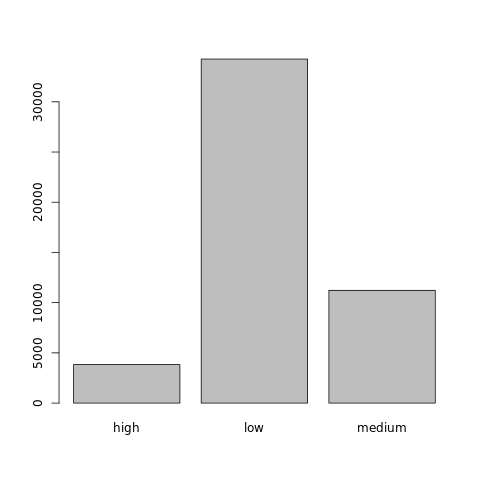

In [26]:
colnames(dftrain_red)

summary (dftrain_red$interest_level)
plot(droplevels(dftrain_red$interest_level))


Most of our sample are not interest in this listing properties

    0     1   1.5     2   2.5     3   3.5     4   4.5     5   5.5     6   6.5 
  313 39406   645  7660   277   743    70   157    29    19     5     4     0 
    7    10 
    0     0 

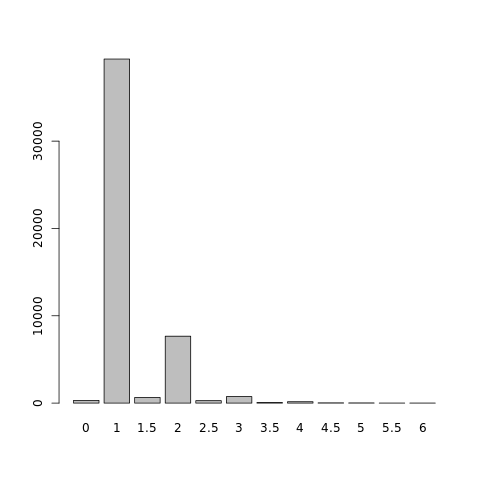

In [27]:
summary (dftrain_red$bathrooms)
plot(droplevels(dftrain_red$bathrooms))

    0     1     2     3     4     5     6     7     8 
 9472 15746 14615  7275  1929   246    45     0     0 

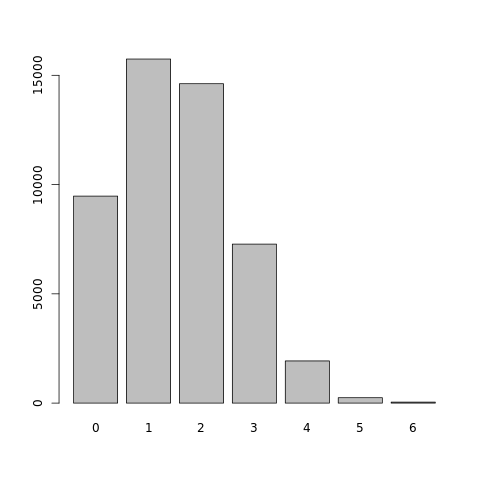

In [28]:
summary(dftrain_red$bedrooms)
plot(droplevels(dftrain_red$bedrooms))

There are more appartmant with 1 bathroom and 1 bedroom in our sample.

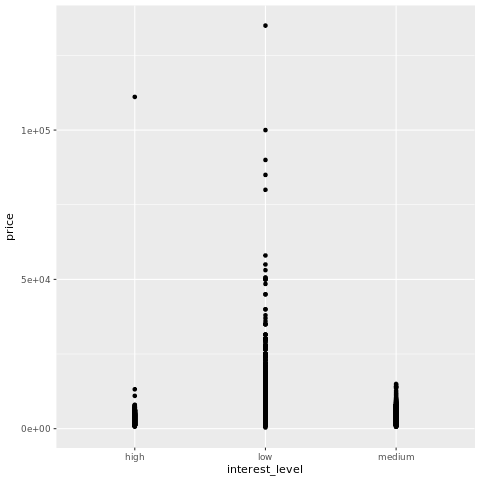

In [29]:
qplot(interest_level,price, data=dftrain_red)


**Note**: Low price appartment are more pupular.

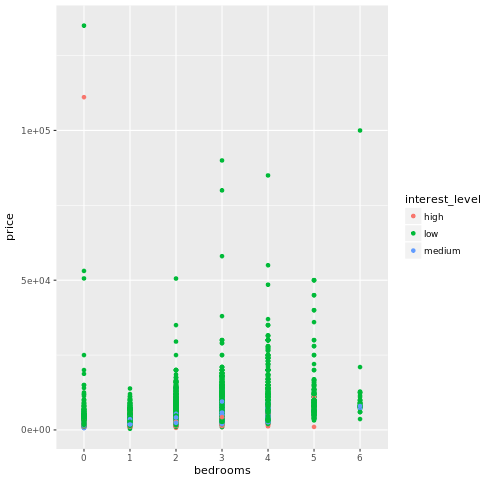

In [30]:
qplot(bedrooms, price, data = dftrain_red, colour =interest_level ) 

**Note**Low price appartment with high number of bedrooms are more pupular

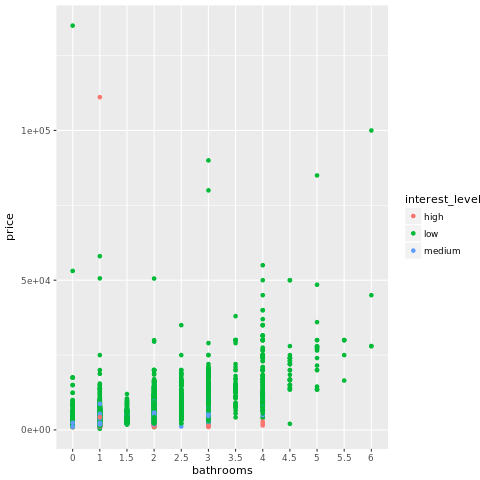

In [31]:
qplot(bathrooms, price, data = dftrain_red, colour =interest_level ) 

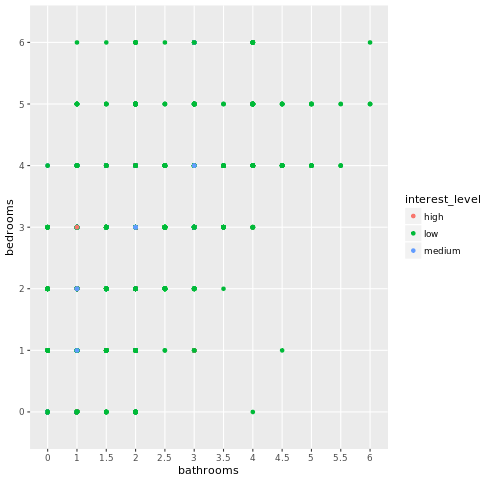

In [32]:
qplot(bathrooms, bedrooms, data = dftrain_red, colour =interest_level ) 

**NOTE** 3 bedrooms appartments with 1 bathroom are very pupular.

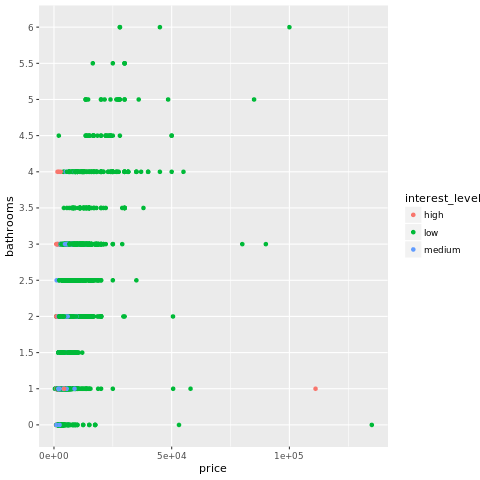

In [33]:
qplot(price,bathrooms, data = dftrain_red, colour =interest_level ) 

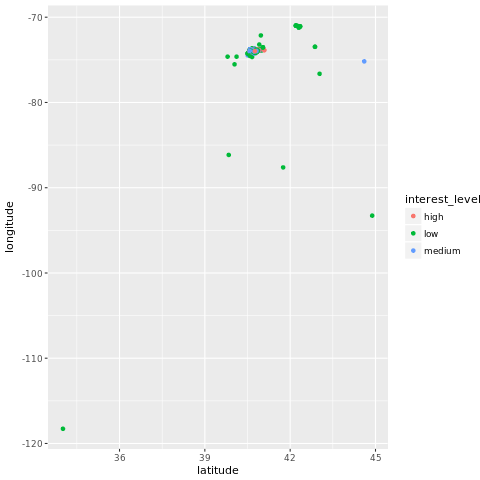

Warning message:
: Removed 3895 rows containing missing values (geom_point).

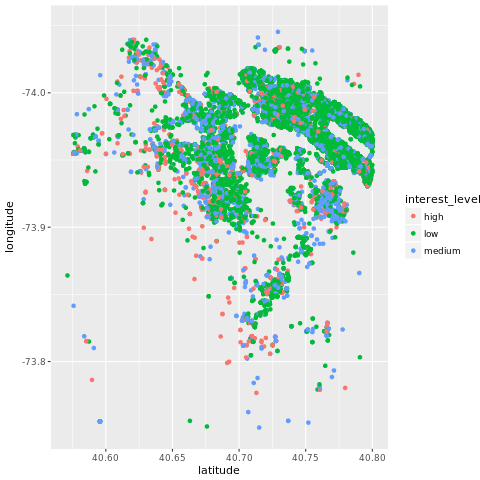

In [34]:
qplot(latitude, longitude, data= dftrain_red, col=interest_level)
qplot(latitude, longitude, data= dftrain_red, col=interest_level, xlim = c(40.57,40.80), ylim = c(-73.75, -74.05))

South-West of NW is more popular. By now, we have some information regarding our data. I would like to look at the high and medium interest level deapthly.

In [35]:
subdata <- subset(dftrain_red, interest_level %in% c("high", "medium"))


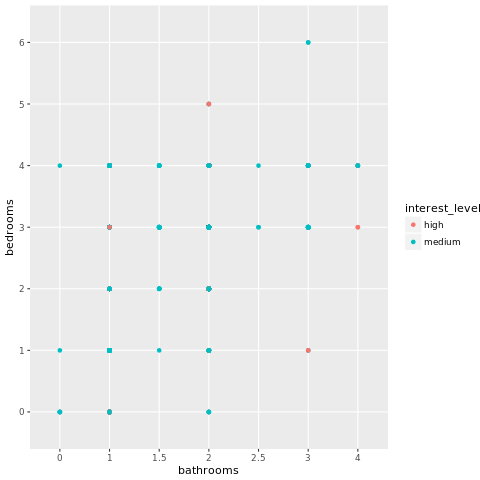

In [36]:
qplot(bathrooms, bedrooms, data = subdata, colour =interest_level )


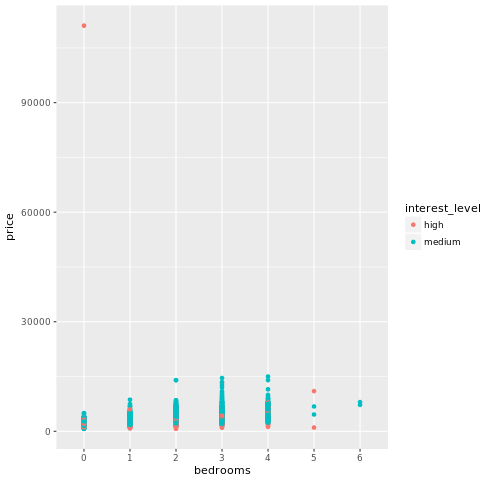

In [37]:
qplot(bedrooms, price, data = subdata, colour =interest_level ) 


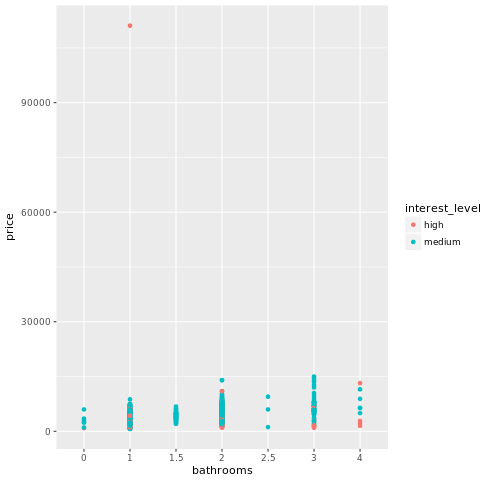

In [38]:
qplot(bathrooms, price, data = subdata, colour =interest_level ) 


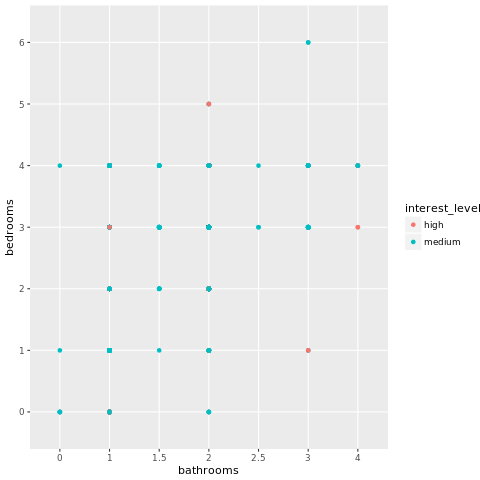

In [39]:
qplot(bathrooms, bedrooms, data = subdata, colour =interest_level ) 


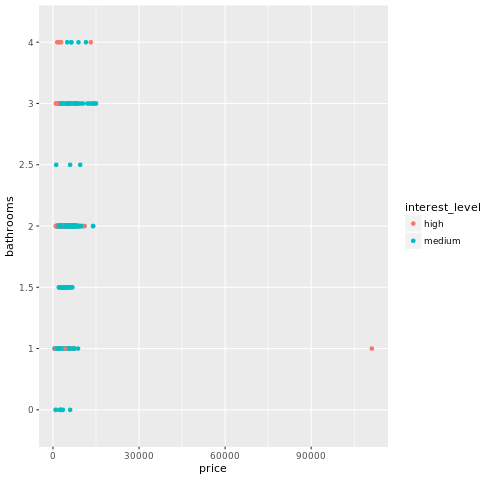

In [40]:
qplot(price,bathrooms, data = subdata, colour =interest_level ) 

Warning message:
: Removed 1375 rows containing missing values (geom_point).

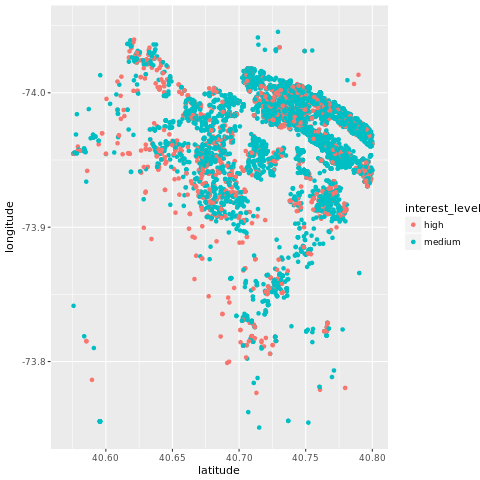

In [41]:
qplot(latitude, longitude, data= subdata, col=interest_level, xlim = c(40.57,40.80), ylim = c(-73.75, -74.05))

We are going to investigate **feathure variable**. We want to know that which words are the most frequent word in this variable. therefore we use below analysis:

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 1

[1] c("Dining Room", "Pre-War", "Laundry in Building", "Dishwasher", "Hardwood Floors", "Dogs Allowed", "Cats Allowed")


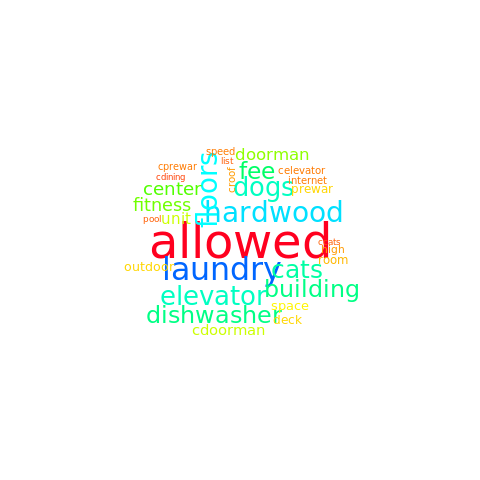

In [71]:
features<- Corpus(VectorSource(dftrain$features))
inspect(features[1])
features_clean<-tm_map(features,removePunctuation)

wordcloud(features_clean, random.order = F, max.words = 30,colors = rainbow(50))



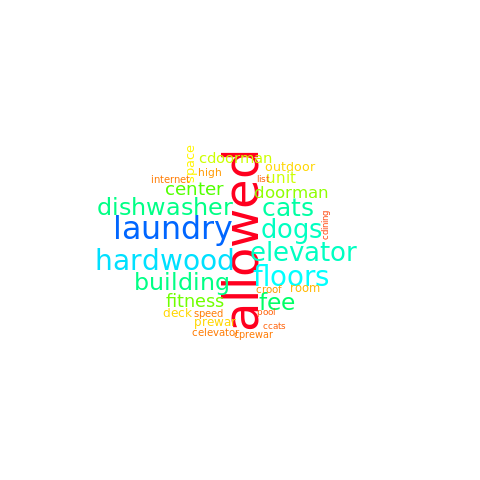

In [73]:
features_clean<-tm_map(features_clean,removeWords,c("allowed","fee","floors","room"))
wordcloud(features_clean, random.order = F, max.words = 30,colors = rainbow(50))



                       word  freq
allowed             allowed 45660
laundry             laundry 27938
hardwood           hardwood 23946
floors               floors 23540
elevator           elevator 21780
dogs                   dogs 21442
cats                   cats 20583
dishwasher       dishwasher 19419
building           building 19298
fee                     fee 18828
center               center 13298
fitness             fitness 12711
doorman             doorman 11568
unit                   unit  9835
cdoorman           cdoorman  9601
space                 space  7563
outdoor             outdoor  7204
deck                   deck  6692
prewar               prewar  6481
room                   room  6008
high                   high  5114
croof                 croof  4659
celevator         celevator  4502
internet           internet  4324
speed                 speed  4304
cprewar             cprewar  4035
list                   list  3218
pool                   pool  3102
ccats         

 Named num [1:1211] 45660 27938 23946 23540 21780 ...
 - attr(*, "names")= chr [1:1211] "allowed" "laundry" "hardwood" "floors" ...


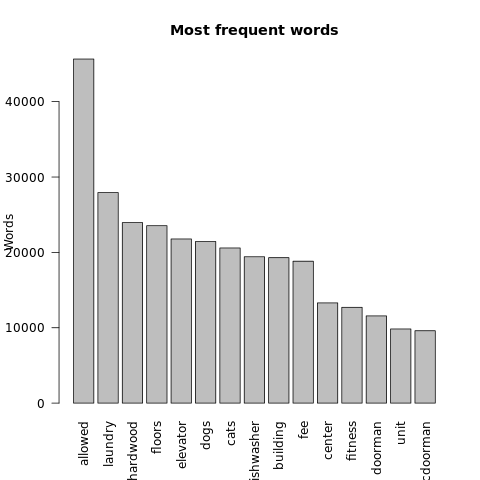

In [70]:
dff<-data.frame(dftrain$listing_id,dftrain$interest_level) 

dtm <- TermDocumentMatrix(features_clean)
m <- as.matrix(dtm)
v <- sort(rowSums(m),decreasing=TRUE)
d <- data.frame(word = names(v),freq=v)
head(d, 70)
str(v)
barplot(d[1:15,]$freq, las = 2, names.arg = d[1:15,]$word,
        main ="Most frequent words",ylab = "Words")

As it can be seen, **allowed**,**laundry**,**hardwood** are 3 words with highest frequency.

### Clasification (interest levels based on price and location)

In this part, I am going to use classification technique to predict **interest_level ** based on **price and Location** to have a better perspective about our data.

In [114]:
colnames(dftrain_red)
dftrain_red_cl<- dftrain_red[,-c(1,2,4,7,8,9,10,11,12,13)]
dftest_red_cl <- dftest_red[,-c(1,2,4,7,8,9,10,11,12,13)]

table(dftrain_red$interest_level)

normalize<- function(x){
  return((x-min(x))/(max(x)-min(x)))
}

dftrain_red_class<- as.data.frame(lapply(dftrain_red_cl[,c(1,2,3)],normalize))
summary(dftrain_red_class)

 [1] "bathrooms"       "bedrooms"        "latitude"        "listing_id"     
 [5] "longitude"       "price"           "interest_level"  "creat_month"    
 [9] "creat_hour"      "creat_day"       "feature_count"   "photo_count"    
[13] "interest_level1"


  high    low medium 
  3839  34262  11227 

    latitude        longitude          price        
 Min.   :0.0000   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:0.6178   1st Qu.:0.9364   1st Qu.:0.01559  
 Median :0.6199   Median :0.9367   Median :0.02042  
 Mean   :0.6199   Mean   :0.9368   Mean   :0.02430  
 3rd Qu.:0.6220   3rd Qu.:0.9372   3rd Qu.:0.02748  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.00000  

In [116]:

head(dftrain_red_cl)
head(dftest_red_cl)


classification<- knn(train = dftrain_red_cl, test = dftest_red_cl, cl=dftrain_red$interest_level ,k=10)
classification



Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)
Warning message:
In install.packages("class"): installation of package ‘class’ had non-zero exit status

  latitude longitude price
1  40.7108  -73.9539  2400
2  40.7513  -73.9722  3800
3  40.7575  -73.9625  3495
4  40.7145  -73.9425  3000
5  40.7439  -73.9743  2795
6  40.7348  -73.9865  7200

  latitude longitude price
1  40.7185  -73.9865  2950
2  40.7278  -74.0000  2850
3  40.7260  -74.0026  2295
4  40.7321  -74.0028  2900
5  40.7054  -74.0095  3254
6  40.7610  -73.9983  4990

    [1] low    low    low    low    low    low    low    low    low    low   
   [11] low    low    low    low    low    low    low    low    low    low   
   [21] low    low    low    low    low    low    low    low    low    low   
   [31] low    low    low    low    low    medium low    low    low    low   
   [41] low    low    low    medium low    low    low    low    low    low   
   [51] low    low    low    low    medium low    low    low    low    low   
   [61] medium medium low    low    low    low    low    low    low    low   
   [71] low    low    low    low    medium low    low    low    low    low   
   [81] low    low    low    low    low    low    low    low    low    low   
   [91] high   low    low    low    low    low    low    low    medium low   
  [101] low    low    low    low    low    low    medium low    low    low   
  [111] low    low    low    low    low    low    low    low    low    low   
  [121] medium medium low    low    low    low    low    low    

In [118]:


classification_trees<-C5.0(dftrain_red_cl,dftrain_red$interest_level)
summary(classification_trees)

p1<- predict(classification_trees,dftest_red_cl)

p1

Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘survival’, ‘Formula’, ‘partykit’

Loading required package: C50



Call:
C5.0.default(x = dftrain_red_cl, y = dftrain_red$interest_level)


C5.0 [Release 2.07 GPL Edition]  	Mon Mar 27 22:54:47 2017
-------------------------------

Class specified by attribute `outcome'

Read 49328 cases (4 attributes) from undefined.data

Decision tree:

price > 2016:
:...longitude > -74: low (37025/10009)
:   longitude <= -74:
:   :...price > 2499: low (6474/1697)
:       price <= 2499:
:       :...latitude <= 40.7103: medium (330/180)
:           latitude > 40.7103:
:           :...price <= 2310:
:               :...longitude <= -74.002: low (58/23)
:               :   longitude > -74.002: medium (22/13)
:               price > 2310:
:               :...price <= 2389: medium (23/8)
:                   price > 2389: low (88/41)
price <= 2016:
:...price <= 1512:
    :...price <= 1300:
    :   :...longitude > -73.7791: medium (7/1)
    :   :   longitude <= -73.7791:
    :   :   :...price <= 700: medium (6/2)
    :   :       price > 700: high (161/43)
    :   price > 

  latitude longitude price interest_level
1  40.7108  -73.9539  2400         medium
2  40.7513  -73.9722  3800            low
3  40.7575  -73.9625  3495         medium
4  40.7145  -73.9425  3000         medium
5  40.7439  -73.9743  2795            low
6  40.7348  -73.9865  7200            low

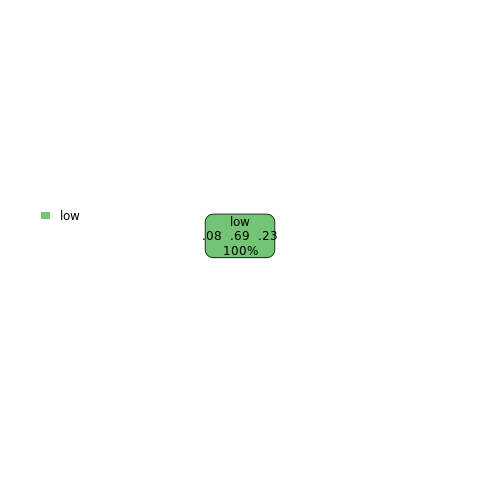

In [124]:

########supervised choices######
dff1 <- data.frame(dftrain_red_cl,interest_level =dftrain_red$interest_level)
head(dff1)
classification_trees1<- rpart(interest_level~., data=dff1, method = "class")
rpart.plot(classification_trees1)


However classification helps us to predict the level of interest, we are looking for the probability of each levels therefore multinomial logistic regression would be a good choise.

### Multinomial logistic Model

Main question of this competition is to calculate probability for each class. Therefore utilizing some techniques like multinomial logistic model is necessary, however, there might be other better models like clustering or classification.

Multinomial logistic regression is applied to model with categorical outcome variables, in which the log odds of the outcomes are modeled as a linear combination of the predictor variables. Multinomial logistic regression is similar to logistic regression. The only differences between them is the number of levels in the response variable. Dependence variable in multinomial logistic regression have more than two possible discrete outcomes. This model is employed to predict the probabilities of the different possible outcomes of a categorically distributed response variable, given a set of independent variables. The independent variables could be continuous or categorical.

Let's look at all pairwise combinations of variables in scatterplots to obtain an idea about variable's relationship.

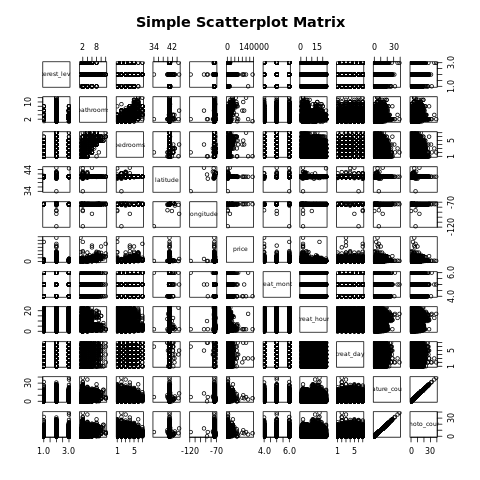

In [129]:
pairs(interest_level ~ bathrooms+bedrooms+ latitude+longitude+price+creat_month+
      creat_hour+creat_day+ feature_count+photo_count, data = dftrain_red,
   main="Simple Scatterplot Matrix")

In [77]:
colnames(dftrain_red)
dftrain_red$interest_level1 <- relevel(dftrain_red$interest_level , ref = "low")
Modelfull <- multinom(interest_level1 ~ bathrooms+bedrooms+ latitude+longitude+price+creat_month+creat_hour+creat_day+ feature_count+photo_count, data = dftrain_red)


 [1] "bathrooms"       "bedrooms"        "latitude"        "listing_id"     
 [5] "longitude"       "price"           "interest_level"  "creat_month"    
 [9] "creat_hour"      "creat_day"       "feature_count"   "photo_count"    
[13] "interest_level1"

# weights:  96 (62 variable)
initial  value 54192.346975 
iter  10 value 42219.423592
iter  20 value 40158.400907
iter  30 value 35820.406256
iter  40 value 34630.988096
iter  50 value 34565.592904
iter  60 value 34540.027534
iter  70 value 34522.645483
iter  80 value 34520.968551
iter  80 value 34520.968448
iter  80 value 34520.968448
final  value 34520.968448 
converged


In [78]:
Modelfull

Call:
multinom(formula = interest_level1 ~ bathrooms + bedrooms + latitude + 
    longitude + price + creat_month + creat_hour + creat_day + 
    feature_count + photo_count, data = dftrain_red)

Coefficients:
       (Intercept) bathrooms1 bathrooms1.5 bathrooms2 bathrooms2.5 bathrooms3
high      148.6088   3.489395  -56.0447806   3.927687  -35.7816142   4.361900
medium    112.7994   2.674423    0.8401102   2.924715    0.3294554   3.193744
       bathrooms3.5 bathrooms4 bathrooms4.5 bathrooms5 bathrooms5.5 bathrooms6
high      -9.175284   5.291568    -3.850732  -2.486034   -0.6542193 -0.5233754
medium    -9.720063   3.102310    -4.296713  -2.510685   -0.6572565 -0.5235679
       bathrooms6.5 bathrooms7 bathrooms10 bedrooms1 bedrooms2 bedrooms3
high              0          0           0 0.1024108 1.1725826  2.101319
medium            0          0           0 0.1668383 0.7962809  1.528412
       bedrooms4 bedrooms5 bedrooms6 bedrooms7 bedrooms8  latitude longitude
high    3.450609  0.784

It should be mentioned that another method of analysis, We can also use **MLOGIT** package to directly calculate the Z values. However,  this package does not include p-value calculation for the regression coefficients, we have calculated p-values by using Wald tests.

In [79]:
summary(Modelfull)

Ztest <- summary(Modelfull)$coefficients/summary(Modelfull)$standard.errors

Ztest

exp(coef(Modelfull))


Warning message:
In sqrt(diag(vc)): NaNs produced

Call:
multinom(formula = interest_level1 ~ bathrooms + bedrooms + latitude + 
    longitude + price + creat_month + creat_hour + creat_day + 
    feature_count + photo_count, data = dftrain_red)

Coefficients:
       (Intercept) bathrooms1 bathrooms1.5 bathrooms2 bathrooms2.5 bathrooms3
high      148.6088   3.489395  -56.0447806   3.927687  -35.7816142   4.361900
medium    112.7994   2.674423    0.8401102   2.924715    0.3294554   3.193744
       bathrooms3.5 bathrooms4 bathrooms4.5 bathrooms5 bathrooms5.5 bathrooms6
high      -9.175284   5.291568    -3.850732  -2.486034   -0.6542193 -0.5233754
medium    -9.720063   3.102310    -4.296713  -2.510685   -0.6572565 -0.5235679
       bathrooms6.5 bathrooms7 bathrooms10 bedrooms1 bedrooms2 bedrooms3
high              0          0           0 0.1024108 1.1725826  2.101319
medium            0          0           0 0.1668383 0.7962809  1.528412
       bedrooms4 bedrooms5 bedrooms6 bedrooms7 bedrooms8  latitude longitude
high    3.450609  0.784

Warning message:
In sqrt(diag(vc)): NaNs producedWarning message:
In sqrt(diag(vc)): NaNs produced

       (Intercept) bathrooms1 bathrooms1.5 bathrooms2  bathrooms2.5 bathrooms3
high       8245218  1344.3566          NaN  1547.3020 -1.677321e+19   77717.54
medium     8332151   250.9191     3530.649   281.5887  3.122128e+04   29535.83
        bathrooms3.5 bathrooms4 bathrooms4.5    bathrooms5  bathrooms5.5
high   -380739968116   946366.3  -4295983294 -2.059730e+14 -1.030866e+15
medium -192677438888   214225.4  -2054674695 -3.236043e+10 -3.170238e+10
          bathrooms6 bathrooms6.5 bathrooms7 bathrooms10 bedrooms1 bedrooms2
high             NaN          NaN        NaN         NaN  34.41222 245.02555
medium -5.428722e+13          NaN        NaN         NaN  10.29742  46.65397
       bedrooms3 bedrooms4 bedrooms5     bedrooms6 bedrooms7 bedrooms8
high    583.3563  9268.048  152129.3 -7.199218e+10         0       NaN
medium  119.7872  2322.266 -125990.6  1.384479e+05       NaN       NaN
        latitude longitude     price creat_month creat_hour creat_day
high   -4267.966  287.7963 -63

        (Intercept) bathrooms1 bathrooms1.5 bathrooms2 bathrooms2.5 bathrooms3
high   3.467137e+64   32.76612 4.571524e-25   50.78936 2.885642e-16   78.40593
medium 9.731111e+48   14.50398 2.316622e+00   18.62892 1.390211e+00   24.37953
       bathrooms3.5 bathrooms4 bathrooms4.5 bathrooms5 bathrooms5.5 bathrooms6
high   1.035678e-04  198.65461   0.02126416 0.08323947    0.5198478  0.5925172
medium 6.006621e-05   22.24929   0.01361323 0.08121262    0.5182712  0.5924032
       bathrooms6.5 bathrooms7 bathrooms10 bedrooms1 bedrooms2 bedrooms3
high              1          1           1  1.107838  3.230325  8.176948
medium            1          1           1  1.181563  2.217279  4.610850
       bedrooms4 bedrooms5  bedrooms6 bedrooms7 bedrooms8   latitude longitude
high    31.51958 2.1903667 0.00272381         1         1 0.05062088  1.504789
medium  10.77125 0.3331416 5.80753563         1         1 0.10341646  1.365968
           price creat_month creat_hour creat_day feature_count photo_

our model seems complicated due to number of different levels that we have in each factors. Let's do some prediction based on the model.

In [80]:
head(perediction <- fitted(Modelfull))
round(head(perediction <- fitted(Modelfull)),2)

        low         high     medium
1 0.5916421 1.067852e-01 0.30157264
2 0.7409283 4.341743e-02 0.21565425
3 0.5369598 1.164493e-01 0.34659095
4 0.8860515 4.514434e-27 0.11394845
5 0.8042915 3.932183e-02 0.15638663
6 0.9451480 1.289785e-03 0.05356222

   low high medium
1 0.59 0.11   0.30
2 0.74 0.04   0.22
3 0.54 0.12   0.35
4 0.89 0.00   0.11
5 0.80 0.04   0.16
6 0.95 0.00   0.05

To examine the model for prediction on **test** data, first we need to clean the test data as well.
    I am going to do similar approchs to train data.

In [86]:
dftest$bathrooms<- as.factor(dftest$bathrooms)
dftest$bedrooms<-as.factor(dftest$bedrooms)
created_test <- strptime(dftest$created, format = "%Y-%m-%d %H:%M:%S")
creat_month <- as.numeric(month(created_test))
creat_hour <-as.numeric(hour(created_test))
creat_day <-as.numeric(wday(created_test))
feature_count <- as.numeric(lapply(dftest$features, length))
photo_count <- as.numeric(lapply(dftest$features, length))

############we just omite text and pic
colnames(dftest)
dftest_red<- data.frame(dftest[,-c(3,4,5,6,7,11,12,14)], 
                        creat_month,creat_hour,creat_day, feature_count,photo_count)



dftest_red <- dftest_red[!(dftest_red$bathrooms==7.5), ]
dftest_red <- dftest_red[!(dftest_red$bathrooms==20), ]
dftest_red_1 <- dftest_red[!(dftest_red$bathrooms==112), ]

na.omit(dftest_red)


 [1] "bathrooms"       "bedrooms"        "building_id"     "created"        
 [5] "description"     "display_address" "features"        "latitude"       
 [9] "listing_id"      "longitude"       "manager_id"      "photos"         
[13] "price"           "street_address" 

      bathrooms bedrooms latitude listing_id longitude   price creat_month
1             1        1  40.7185    7142618  -73.9865    2950           6
2             1        2  40.7278    7210040  -74.0000    2850           6
3             1        0  40.7260    7174566  -74.0026    2295           6
4             1        2  40.7321    7191391  -74.0028    2900           6
5             1        1  40.7054    7171695  -74.0095    3254           6
6             2        2  40.7610    7225206  -73.9983    4990           6
7           3.5        4  40.7358    7200075  -73.9877   20000           6
8             1        0  40.7814    7145074  -73.9507    2150           6
9             2        4  40.7216    7193645  -73.9927    6500           6
10            1        1  40.7553    7147703  -73.9953    3365           6
11            1        1  40.7623    7182218  -73.9590    2500           6
12            1        1  40.7678    7132136  -73.9915    3777           6
13            1        0 

In [87]:
dt = data.table(dftest_red)
dt[duplicated(listing_id), cbind(.SD[1], number = .N), by = listing_id]


Empty data.table (0 rows) of 12 cols: listing_id,bathrooms,bedrooms,latitude,longitude,price...
NULL

In [88]:
dftest_red<-dftest_red[!(dftest_red$bathrooms==7.5), ]
dftest_red<-dftest_red[!(dftest_red$bathrooms==20), ]
dftest_red<-dftest_red[!(dftest_red$bathrooms==112), ]


### Using Test Dataset to Predict Level of Interest

At this stage we are going to define the predicted values based on full model for test data. So we have: 

In [89]:
Final_prediction_full<-predict(Modelfull, newdata = dftest_red, "probs")

In [93]:
data.frame(dftest_red$listing_id,round(Final_prediction_full,2))

      dftest_red.listing_id  low high medium
1                   7142618 0.71 0.06   0.23
2                   7210040 0.59 0.12   0.30
3                   7174566 0.75 0.06   0.19
4                   7191391 0.63 0.10   0.27
5                   7171695 0.67 0.06   0.28
6                   7225206 0.80 0.02   0.19
7                   7200075 1.00 0.00   0.00
8                   7145074 0.73 0.07   0.20
9                   7193645 0.83 0.01   0.16
10                  7147703 0.84 0.02   0.14
11                  7182218 0.61 0.12   0.27
12                  7132136 0.76 0.03   0.21
13                  7130670 0.66 0.09   0.25
14                  7151855 0.95 0.00   0.05
15                  7158358 0.75 0.05   0.20
16                  7221001 0.92 0.00   0.07
17                  7100305 0.23 0.35   0.43
18                  7096581 0.69 0.04   0.27
19                  7177904 0.73 0.05   0.22
20                  7122823 0.55 0.18   0.28
21                  7183502 0.95 0.00   0.05
22        

The probability of different levels of interest for each listing_id is obtained. Let's look at the bar chart to figure out how the predictions look like, Does it look like the train's behaviour?

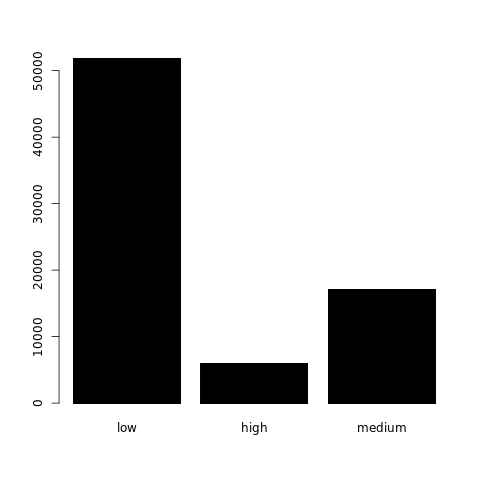

In [97]:
barplot(round(Final_prediction_full,2))

Yess! It is quite similar. Low interest has the most frequency between 2 other variables.

- **Note**

I did not use other methods to evalute the model such as cross validation due to the time limitation. I assume that this model fit well and I move to next step. 

### Identify Best Variables for Modeling Based On Stepwise Variable Selection

This section aims to choose an appropriate model for the interest level based on the best variables. To achieve this aim, we should, firstly, add all independent variables into the model(Modelfull) and find the most effective ones. I am going to use The stepwise method which combines the concepts of the forward and backward selection and allows for the addition or deletion of a predictor variable at each step before it arrives at the optimal model. 

In [96]:
install.packages("MASS")
library("MASS")
step <- stepAIC(Modelfull, direction="both")
step$anova


Installing package into ‘/resources/common/R/Library’
(as ‘lib’ is unspecified)


Start:  AIC=69141.94
interest_level1 ~ bathrooms + bedrooms + latitude + longitude + 
    price + creat_month + creat_hour + creat_day + feature_count + 
    photo_count

# weights:  54 (34 variable)
initial  value 54192.346975 
iter  10 value 41953.651793
iter  20 value 39965.914980
iter  30 value 34962.674909
iter  40 value 34836.881254
iter  50 value 34809.265620
iter  60 value 34803.548454
final  value 34803.256635 
converged
# weights:  72 (46 variable)
initial  value 54192.346975 
iter  10 value 42300.396922
iter  20 value 38424.387869
iter  30 value 35964.561124
iter  40 value 35884.423151
iter  50 value 35841.210350
iter  60 value 35830.654720
iter  70 value 35829.415631
final  value 35828.580206 
converged
# weights:  93 (60 variable)
initial  value 54192.346975 
iter  10 value 41992.902465
iter  20 value 39430.882817
iter  30 value 35161.312042
iter  40 value 34613.217398
iter  50 value 34585.783668
iter  60 value 34577.041929
final  value 34575.831003 
converged
# weights:  

Stepwise Model Path 
Analysis of Deviance Table

Initial Model:
interest_level1 ~ bathrooms + bedrooms + latitude + longitude + 
    price + creat_month + creat_hour + creat_day + feature_count + 
    photo_count

Final Model:
interest_level1 ~ bathrooms + bedrooms + latitude + longitude + 
    price + creat_month + creat_hour + creat_day + feature_count


  Step Df Deviance Resid. Df Resid. Dev      AIC
1                      49278   69041.94 69141.94

As you can see, Final Model includes all variables except photo_count variable.

- **Final Model:
interest_level1 ~ bathrooms + bedrooms + latitude + longitude + **
    **price + creat_month + creat_hour + creat_day + feature_count**


The aim of the algorithm is to minimize something that’s called the  Akaike's Information Criterion (AIC), a parameter that considers both, the fit of the model as well as the number of parameters used.

Let's build the final Model and find the prediction based on new model

In [98]:
colnames(dftrain_red)
dftrain_red$interest_level1 <- relevel(dftrain_red$interest_level , ref = "low")

Modelfinal <- multinom(interest_level1 ~ bathrooms+bedrooms+ latitude+longitude+price+creat_month+creat_hour+creat_day+ feature_count, data = dftrain_red)


 [1] "bathrooms"       "bedrooms"        "latitude"        "listing_id"     
 [5] "longitude"       "price"           "interest_level"  "creat_month"    
 [9] "creat_hour"      "creat_day"       "feature_count"   "photo_count"    
[13] "interest_level1"

# weights:  93 (60 variable)
initial  value 54192.346975 
iter  10 value 41416.635881
iter  20 value 39585.000290
iter  30 value 35869.131285
iter  40 value 34602.656743
iter  50 value 34569.794577
iter  60 value 34537.673577
iter  70 value 34521.779650
final  value 34520.968569 
converged


In [99]:
summary(Modelfinal)

Ztest <- summary(Modelfinal)$coefficients/summary(Modelfinal)$standard.errors

Ztest

exp(coef(Modelfinal))


head(perediction <- fitted(Modelfinal))


Warning message:
In sqrt(diag(vc)): NaNs produced

Call:
multinom(formula = interest_level1 ~ bathrooms + bedrooms + latitude + 
    longitude + price + creat_month + creat_hour + creat_day + 
    feature_count, data = dftrain_red)

Coefficients:
       (Intercept) bathrooms1 bathrooms1.5 bathrooms2 bathrooms2.5 bathrooms3
high      148.5856   3.494346  -73.6172018   3.932655  -34.1942637   4.367417
medium    112.8024   2.674304    0.8402322   2.924578    0.3294899   3.193835
       bathrooms3.5 bathrooms4 bathrooms4.5 bathrooms5 bathrooms5.5 bathrooms6
high      -8.577458   5.296205    -3.597558  -2.322741   -0.6112475 -0.4889980
medium    -9.292412   3.101649    -4.262587  -2.345801   -0.6143196 -0.4892283
       bathrooms6.5 bathrooms7 bathrooms10 bedrooms1 bedrooms2 bedrooms3
high              0          0           0 0.1023804 1.1725486  2.101430
medium            0          0           0 0.1667793 0.7962076  1.528305
       bedrooms4  bedrooms5 bedrooms6 bedrooms7 bedrooms8  latitude longitude
high    3.450179  0.7829084 -5.53327

Warning message:
In sqrt(diag(vc)): NaNs producedWarning message:
In sqrt(diag(vc)): NaNs produced

       (Intercept) bathrooms1 bathrooms1.5 bathrooms2 bathrooms2.5 bathrooms3
high       8242948  1346.3151          NaN  1549.3193          NaN   77796.68
medium     8331634   250.9089     3530.614   281.5776     31220.85   29527.99
        bathrooms3.5 bathrooms4 bathrooms4.5    bathrooms5  bathrooms5.5
high   -196592571347     942518  -3131502641 -1.640273e+14 -9.304847e+14
medium -119994987100     214224  -1969859805 -2.564814e+10 -2.839879e+10
          bathrooms6 bathrooms6.5 bathrooms7 bathrooms10 bedrooms1 bedrooms2
high   -1.536196e+17            0        NaN           0  34.40435 245.02080
medium -4.903366e+13          NaN        NaN         NaN  10.29364  46.64911
       bedrooms3 bedrooms4 bedrooms5     bedrooms6 bedrooms7 bedrooms8
high    583.3689  9259.259  151990.4 -4.595472e+10       NaN       NaN
medium  119.7782  2322.183 -126071.6  1.383831e+05       NaN       NaN
        latitude longitude     price creat_month creat_hour creat_day
high   -4267.115  287.7585 -63.65

        (Intercept) bathrooms1 bathrooms1.5 bathrooms2 bathrooms2.5 bathrooms3
high   3.387649e+64   32.92875 1.067715e-32   51.04231 1.411302e-15   78.83976
medium 9.760055e+48   14.50226 2.316905e+00   18.62636 1.390259e+00   24.38175
       bathrooms3.5 bathrooms4 bathrooms4.5 bathrooms5 bathrooms5.5 bathrooms6
high   1.883031e-04  199.57806   0.02739053 0.09800458    0.5426735  0.6132406
medium 9.212056e-05   22.23458   0.01408581 0.09577044    0.5410088  0.6130993
       bathrooms6.5 bathrooms7 bathrooms10 bedrooms1 bedrooms2 bedrooms3
high              1          1           1  1.107805  3.230215  8.177855
medium            1          1           1  1.181493  2.217117  4.610357
       bedrooms4 bedrooms5   bedrooms6 bedrooms7 bedrooms8  latitude longitude
high    31.50604 2.1878262 0.003953006         1         1 0.0506387  1.504707
medium  10.77022 0.3329383 5.810961519         1         1 0.1034084  1.365962
           price creat_month creat_hour creat_day feature_count
high  

        low         high     medium
1 0.5916507 1.067729e-01 0.30157634
2 0.7409311 4.341743e-02 0.21565148
3 0.5369805 1.164278e-01 0.34659171
4 0.8860309 1.049211e-34 0.11396907
5 0.8042791 3.932540e-02 0.15639547
6 0.9451502 1.290200e-03 0.05355956

In [101]:
Final_prediction_final <- predict( Modelfinal, newdata = data.frame(dftest_red), "probs")

In [103]:
data.frame(listing_id=dftest_red$listing_id,round(Final_prediction_final,2))

      listing_id  low high medium
1        7142618 0.71 0.06   0.23
2        7210040 0.59 0.12   0.30
3        7174566 0.75 0.06   0.19
4        7191391 0.63 0.10   0.27
5        7171695 0.67 0.06   0.28
6        7225206 0.80 0.02   0.19
7        7200075 1.00 0.00   0.00
8        7145074 0.73 0.07   0.20
9        7193645 0.83 0.01   0.16
10       7147703 0.84 0.02   0.14
11       7182218 0.61 0.12   0.27
12       7132136 0.76 0.03   0.21
13       7130670 0.66 0.09   0.25
14       7151855 0.95 0.00   0.05
15       7158358 0.75 0.05   0.20
16       7221001 0.92 0.00   0.07
17       7100305 0.23 0.35   0.43
18       7096581 0.69 0.04   0.27
19       7177904 0.73 0.05   0.22
20       7122823 0.55 0.18   0.28
21       7183502 0.95 0.00   0.05
22       7170627 0.55 0.05   0.40
23       7154826 0.65 0.11   0.25
24       7155276 0.93 0.01   0.07
25       7126641 0.73 0.05   0.22
26       7096119 0.69 0.08   0.23
27       7197172 0.45 0.16   0.39
28       7189973 0.80 0.03   0.17
29       71230

In Conclusion, a set of predicted probabilities is calculated (one for every listing ID) based on the final model.

It is noticeable that based on model's AIC, there is still some rooms for model improvement. In this situation maybe regularization works better. I have not tested all possible methods in this assignment. Based on our time, I choose multinomial logistic regression however other methods might work well. 